# BayesOPT Example for showing Gittins >> EIpu
Extension of the numerical examples presented in Theorem 1 of Raul and Peter's paper which aimed to show the limitation of EIpu and EI. This experiment extends the scope from Pandora's box (discrete finite points) to Bayesian optimization (continuous domain) and compares Gittins with EIpu/EI.

In [1]:
import torch
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

## Define the amplitude function and the cost function 
The continuous amplitude function and the continuous cost function are constructed based on the variances and costs of the discrete finite points provided in the original example

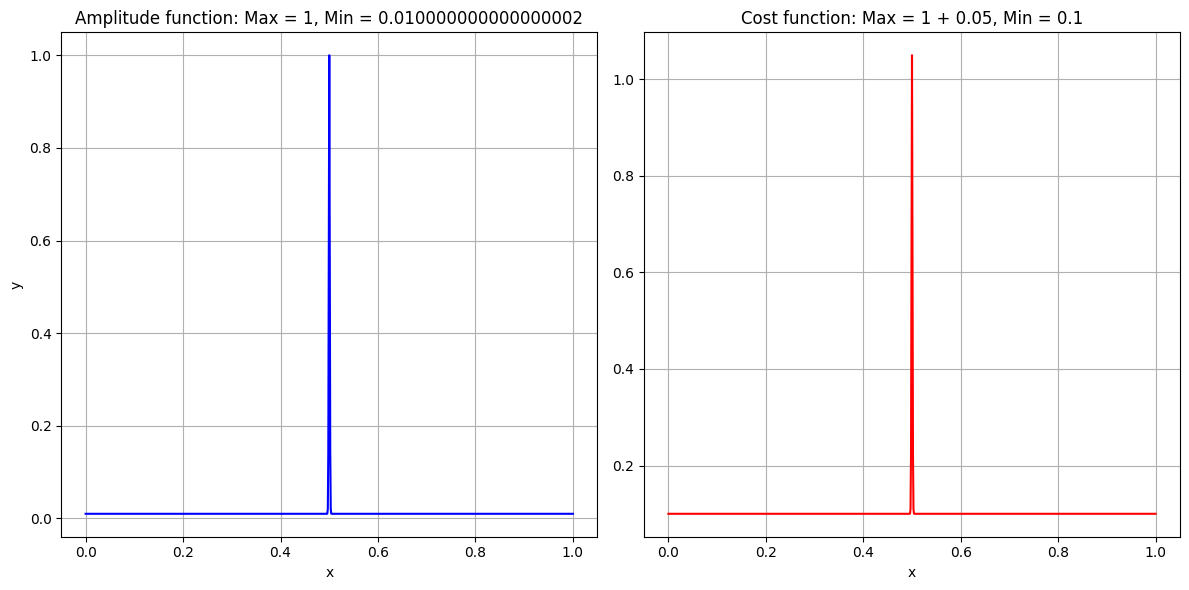

In [2]:
import matplotlib.pyplot as plt
# Define typical small values for epsilon and delta, and a moderate value for K
epsilon = 0.1
delta = 0.05
amplitude_function_width = 0.001
cost_function_width = 0.001

# Define the functions for the amplitude and the cost
def amplitude_function(x):
    width = amplitude_function_width  # Width of the bump to cover only the central point
    amplitude = torch.exp(-((x - 0.5)**2) / (2 * width**2)) * (1 - epsilon**2) + epsilon**2
    return amplitude.squeeze(-1)

def cost_function(x):
    width = cost_function_width  # Width of the bump to cover only the central point
    peak_height = 1 + delta - epsilon
    cost = torch.exp(-((x - 0.5)**2) / (2 * width**2)) * peak_height + epsilon
    return cost.squeeze(-1)

# Generate x values from 0 to 1
x_values = torch.linspace(0, 1, 1001, dtype=torch.float64, device=device)

# Generate y values for amplitude function and cost function
y_values_amplitude = [amplitude_function(x) for x in x_values]
y_values_cost = [cost_function(x) for x in x_values]

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for amplitude function
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for cost function
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {delta}, Min = {epsilon}")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

### TODO
Adjust the hyperparamters to get a larger discrepancy between EIpu and Gittins

### Question
Is it necessary to pass epsilon = 0.1, delta = 0.05, K = 100 as parameters to amplitude_function and cost_function?

## Define the objective function
The objective functions are constructed as sample paths drawn from the Matern kernel multiplied by the amplitude function

In [3]:
from pandora_bayesopt.utils import create_objective_function
# Create the objective model
dim = 1
nu = 2.5
lengthscale = 0.01
outputscale = 1.0
num_rff_features = 1280
seed = 0
torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

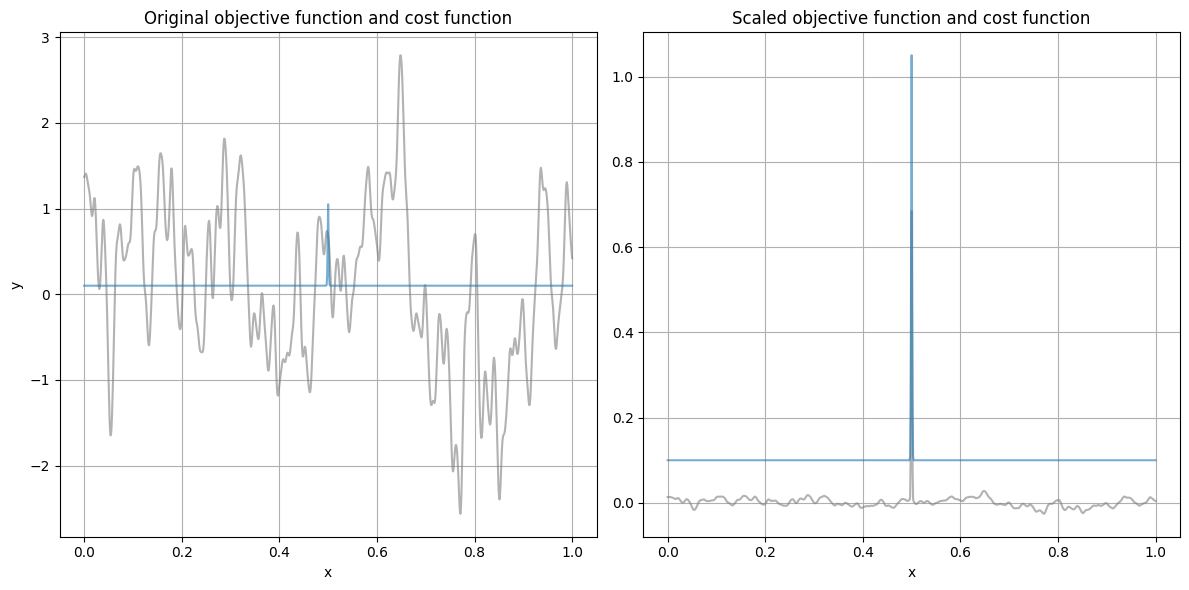

In [4]:
test_x = torch.linspace(0, 1, 1001, dtype=torch.float64, device=device)

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for original objective function
plt.subplot(1, 2, 1)
plt.plot(test_x.cpu().numpy(), matern_sample(test_x.view(-1,1)).numpy(), color='tab:grey', label="Original objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Original objective function and cost function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for scaled objective function
plt.subplot(1, 2, 2)
plt.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), color='tab:grey', label="Scaled objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Scaled objective function and cost function")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        
    
    ax.legend(['Objective Function', 'Observed Data', 'Mean', 'Confidence'])

### Define a customized kernel as Matern kernel with input-dependent amplitude (outputscale)

In [6]:
from gpytorch.kernels import MaternKernel
from pandora_bayesopt.kernel import VariableAmplitudeKernel

### Note
This class VariableAmplitudeKernel can be found in pandora_bayesopt.kernel

## Fit a GP model with observation data and a specified kernel

In [7]:
from pandora_bayesopt.utils import fit_gp_model

### Note
This function can be found in pandora_bayesopt.utils

In [8]:
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

### Question
Instead of setting the kernel inside fit_gp_model with given smoothness and lengthscale parameters, I set the kernel before running the BayesOPT loop so that I can also use fit_gp_model with a standard Matern kernel (base_kernel) for other tasks. However, it seems that if I only set it once, then it would be a different initial kernel when I run another policy. Not sure why this happens. To avoid such issues, I reset it before running every policy.

In [9]:
maximize = True
budget = 1+delta

In [10]:
from pandora_bayesopt.utils import find_global_optimum
global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)
print("global_optimum", global_optimum_point, global_optimum_value)
print()

global_optimum tensor([0.5000]) 0.685532617060132



## Test EI policy

initial x: tensor([[0.]])
initial y: tensor([0.0137])
best oberved value: 0.013677983402295115
Iteration 0, measuring at x=0.4999999999891902, y=0.6845484702663631


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


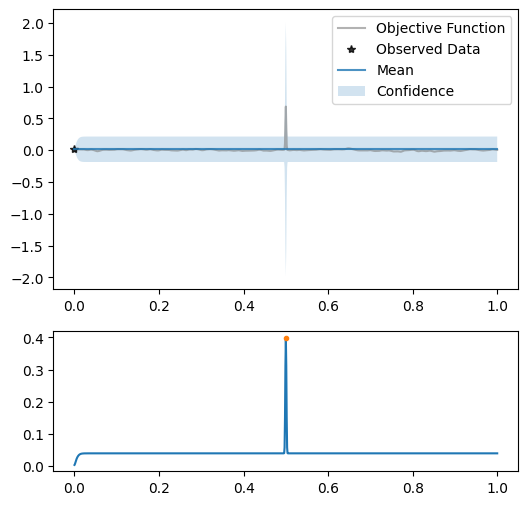

best oberved value: 0.6845484702663631
new cost: 1.05
cumulative cost: 1.05


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3491]), std = tensor([0.4744])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 1, measuring at x=0.49960372035294764, y=0.6485925312745706


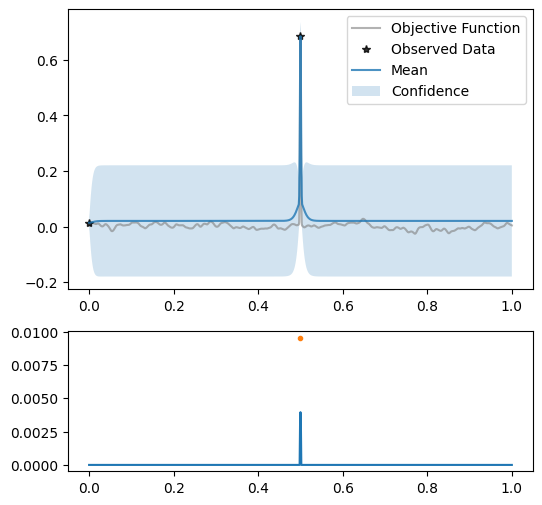

best oberved value: 0.6845484702663631
new cost: 0.9782604636335503
cumulative cost: 2.0282604636335506


In [11]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.kernels import MaternKernel

x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
print("initial x:", x)
print("initial y:", y)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EI_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.stack([torch.zeros(dim), torch.ones(dim)]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Plot the posterior and the EI
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the posterior
    plot_posterior(ax1,objective_function,model,test_x,x,y)
    
    # Plot EI
    acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'.')
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### Question
- Do I need to care about these warnings?

## Test EI per unit cost policy

best oberved value: 0.013677983402295115


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 0, measuring at x=0.4977799162250769, y=0.0697512038250151


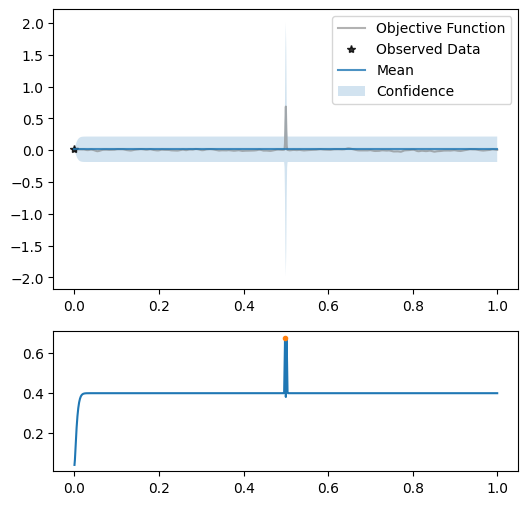

best oberved value: 0.0697512038250151
new cost: 0.18080800244276785
cumulative cost: 0.18080800244276785
Iteration 1, measuring at x=0.5020388642675593, y=0.07452962496483359


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0417]), std = tensor([0.0396])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


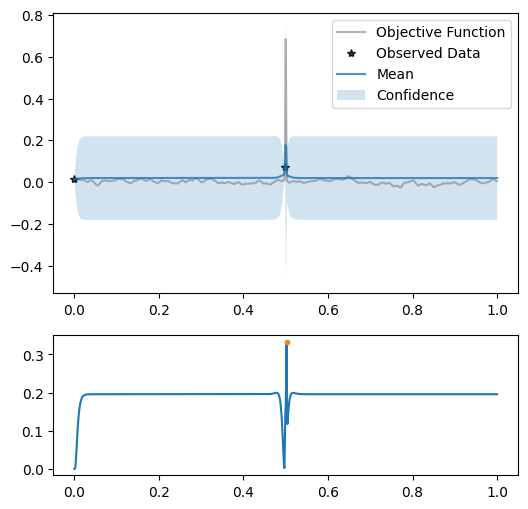

best oberved value: 0.07452962496483359
new cost: 0.21886379215698207
cumulative cost: 0.3996717945997499
Iteration 2, measuring at x=0.4746369953730184, y=0.0025433894602558444


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0527]), std = tensor([0.0338])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


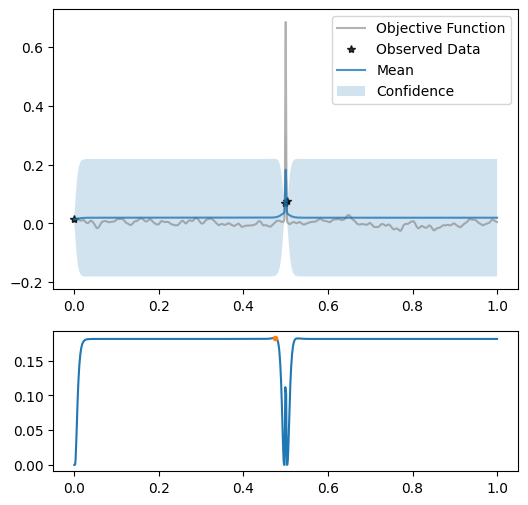

best oberved value: 0.07452962496483359
new cost: 0.1
cumulative cost: 0.49967179459974986
Iteration 3, measuring at x=0.5275810674221871, y=0.0012471602703579584


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0401]), std = tensor([0.0373])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


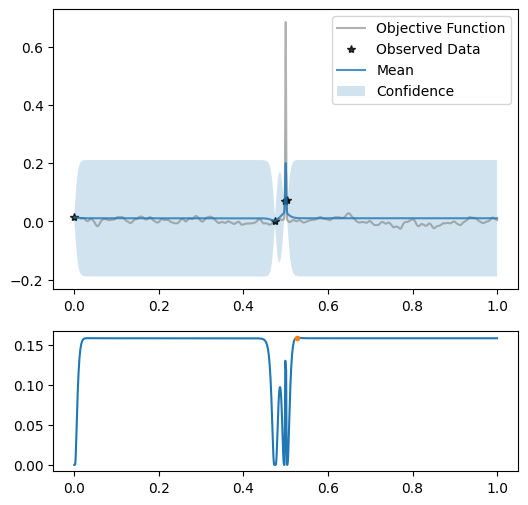

best oberved value: 0.07452962496483359
new cost: 0.1
cumulative cost: 0.5996717945997498
Iteration 4, measuring at x=0.02645897215641457, y=0.004844301438385496


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0323]), std = tensor([0.0367])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


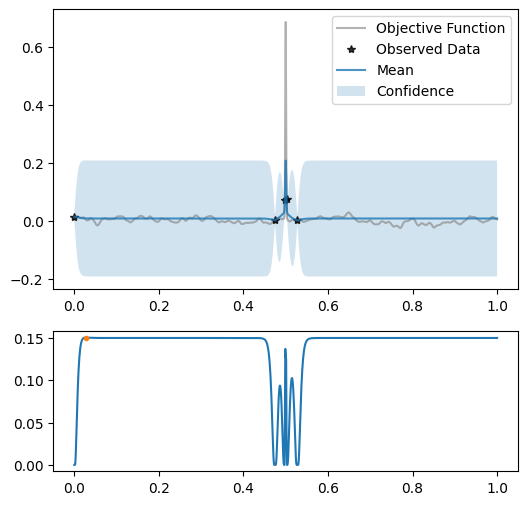

best oberved value: 0.07452962496483359
new cost: 0.1
cumulative cost: 0.6996717945997498
Iteration 5, measuring at x=1.0, y=0.00421515667012155


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0278]), std = tensor([0.0347])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


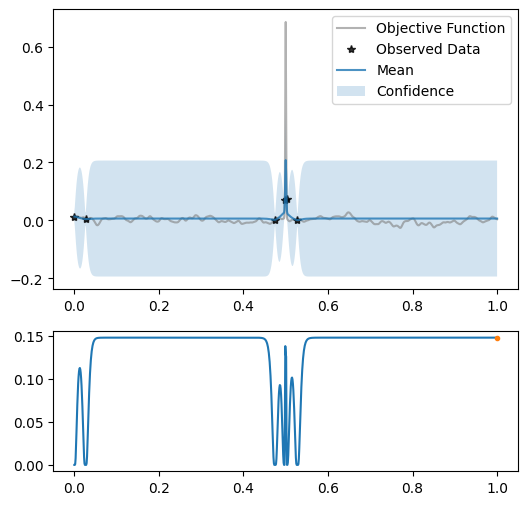

best oberved value: 0.07452962496483359
new cost: 0.1
cumulative cost: 0.7996717945997498


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0244]), std = tensor([0.0329])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 6, measuring at x=0.8126127708749804, y=-0.01605461955787808


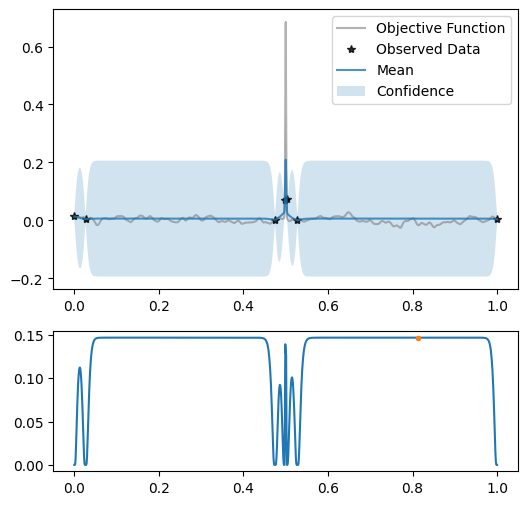

best oberved value: 0.07452962496483359
new cost: 0.1
cumulative cost: 0.8996717945997498


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0193]), std = tensor([0.0336])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 7, measuring at x=0.060044981076009744, y=-0.007545873744220664


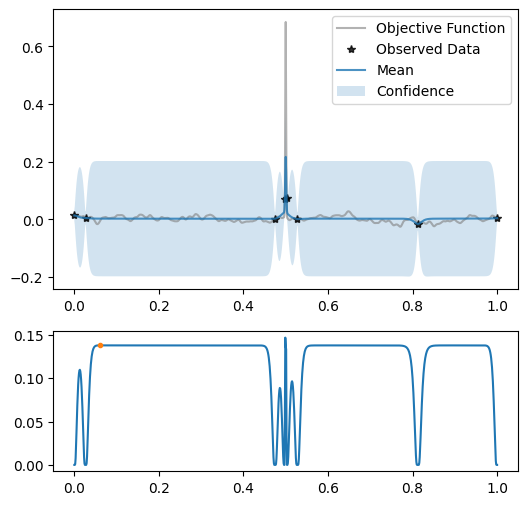

best oberved value: 0.07452962496483359
new cost: 0.1
cumulative cost: 0.9996717945997498


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0164]), std = tensor([0.0327])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 8, measuring at x=0.49895661447685913, y=0.4221413038840538


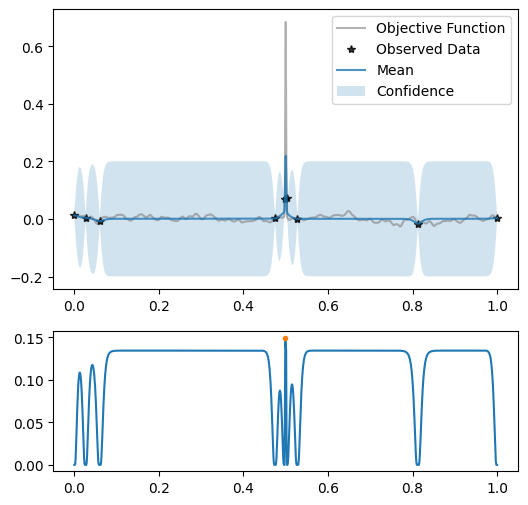

best oberved value: 0.4221413038840538
new cost: 0.6512207199672023
cumulative cost: 1.650892514566952


In [12]:
from pandora_bayesopt.acquisition import ExpectedImprovementWithCost

x = torch.zeros(dim).unsqueeze(-1)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()
EIpu_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EIpu_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EIpu
    EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
    new_point, new_point_EIpu = optimize_acqf(
        acq_function=EIpu,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Plot the posterior and the EIpu
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the posterior
    plot_posterior(ax1,objective_function,model,test_x,x,y)
    
    # Plot EIpu
    acq = EIpu.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EIpu.numpy(),'.')
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EIpu_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EIpu_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### TODO
- Test EI with cost cooling as well

## Test Hyperparamter-free Gittins policy

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


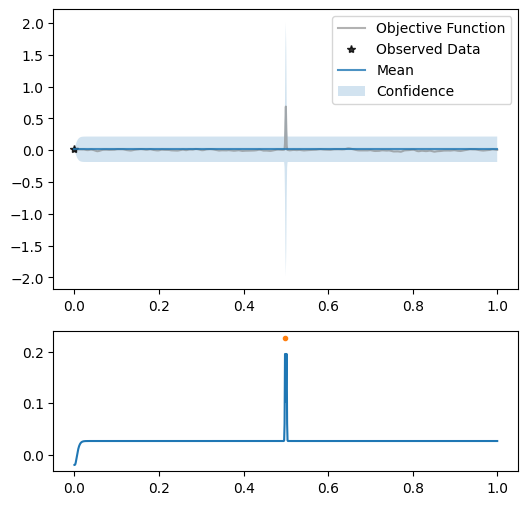

Iteration: 0
best oberved value: 0.013677983402295115
new point: [[0.49849211]]
new value: 0.240122371061036
new acq: 0.22783193574034766
lmbda: tensor(0.3386)

new cost: 0.40478202970769617
cumulative cost: 0.40478202970769617


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1269]), std = tensor([0.1601])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


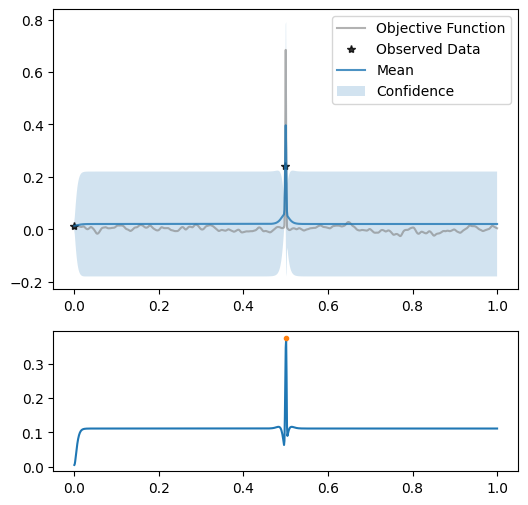

Iteration: 1
best oberved value: 0.240122371061036
new point: [[0.50074949]]
new value: 0.4897971642449848
new acq: 0.376954086901075
lmbda: tensor(0.0990)

new cost: 0.8173708255641834
cumulative cost: 1.2221528552718794


In [13]:
from pandora_bayesopt.acquisition import ExpectedImprovementWithCost
from pandora_bayesopt.acquisition import GittinsIndex

x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GI_best = [best_f] # This will store the best value
cumulative_cost = 0
GI_cumulative_cost_history = [0]

i = 0

while True:

    model = fit_gp_model(x, y, kernel)
    
    # Optimize EIpu
    EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
    _, new_point_EIpu = optimize_acqf(
        acq_function=EIpu,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Optimize Gittins
    GI = GittinsIndex(model=model, lmbda=new_point_EIpu/2, maximize=maximize, cost=cost_function)
    new_point, new_point_GI = optimize_acqf(
        acq_function=GI,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GI_acq = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GI_acq.detach().numpy(), '-', new_point.item(), new_point_GI.item(), '.')
    plt.show()

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GI.item())
    print("lmbda:", new_point_EIpu/2)
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GI_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    GI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

Iteration: 0
new_point_EIpu: tensor(0.6772)
lmbda: tensor(0.3386)


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


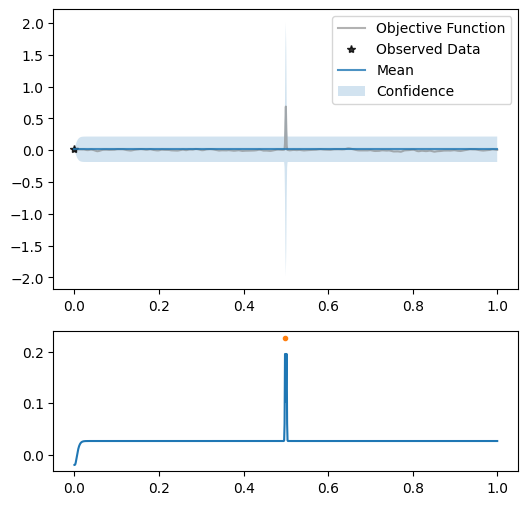

best oberved value: 0.013677983402295115
new point: [[0.49849211]]
new value: 0.24012244349612943
new acq: 0.22783193574765237
lmbda: tensor(0.3386)

new cost: 0.4047821261883122
cumulative cost: 0.4047821261883122
best_f: 0.24012244349612943

Iteration: 1
new_point_EIpu: tensor(0.1979)
lmbda: tensor(0.0990)


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1269]), std = tensor([0.1601])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


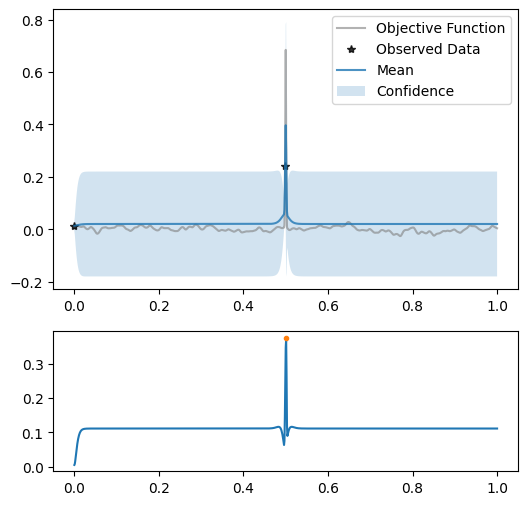

best oberved value: 0.24012244349612943
new point: [[0.50074949]]
new value: 0.48979611367782194
new acq: 0.376954159131765
lmbda: tensor(0.0990)

new cost: 0.8173694323398587
cumulative cost: 1.222151558528171
best_f: 0.48979611367782194



In [14]:
x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIfree_best = [best_f] # This will store the best value
cumulative_cost = 0
GIfree_cumulative_cost_history = [0]

i = 0
while True:
    
    print("Iteration:", i)
    
    # Fit the model
    model = fit_gp_model(x, y, kernel)
    
    if i == 0 or new_point_GI.item() < best_f:
        
        # Optimize EIpu
        EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
        new_point, new_point_EIpu = optimize_acqf(
            acq_function=EIpu,
            bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
            q=1,
            num_restarts=20,
            raw_samples=1024,
            options={'method': 'L-BFGS-B'},
        )
        print("new_point_EIpu:", new_point_EIpu)

        # # Plot the posterior and the EIpu
        # f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
        # # Plot the posterior
        # plot_posterior(ax1, objective_function, model, test_x, x, y)
    
        # # Plot EIpu
        # EIpu_acq = EIpu.forward(test_x.unsqueeze(1).unsqueeze(1))
        # ax2.plot(test_x.numpy(), EIpu_acq.detach().numpy(), '-', new_point.item(), new_point_EIpu.item(), '.')
        # plt.show()
        
    print("lmbda:", new_point_EIpu/2)

    # Optimize Gittins
    GI = GittinsIndex(model=model, lmbda=new_point_EIpu/2, maximize=maximize, cost=cost_function)
    new_point, new_point_GI = optimize_acqf(
        acq_function=GI,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GI_acq = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GI_acq.detach().numpy(), '-', new_point.item(), new_point_GI.item(), '.')
    plt.show()

    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GI.item())
    print("lmbda:", new_point_EIpu/2)
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIfree_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    print("best_f:", best_f)
    print()
    GIfree_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### Note
- Actually this hyperparameter-free Gittins policy can also perform well when the budget is higher

### TODO
- Check if we need a smaller intial lambda for hyperparameter-free Gittins policy

## Test Gittins policy with a small constant lambda

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


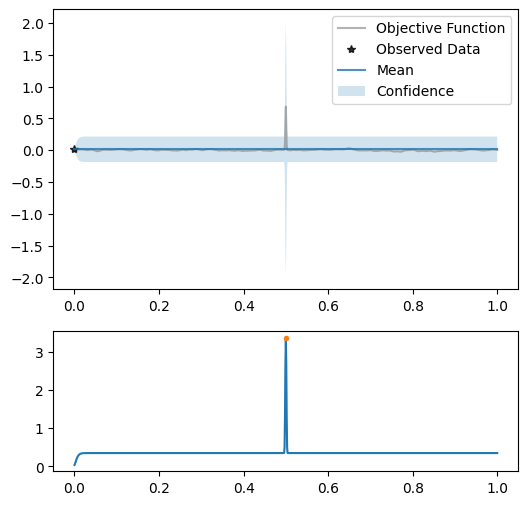

Iteration: 0
best oberved value: 0.013677983402295115
new point: [[0.5]]
new value: 0.6845484677532084
new acq: 3.364017668834485

new cost: 1.0499999999999992
cumulative cost: 1.0499999999999992


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3491]), std = tensor([0.4744])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


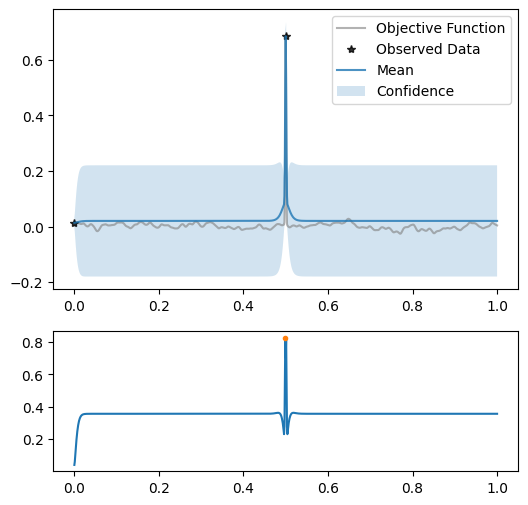

Iteration: 1
best oberved value: 0.6845484677532084
new point: [[0.49917417]]
new value: 0.5111528327494298
new acq: 0.8270146606215294

new cost: 0.775509351397757
cumulative cost: 1.825509351397756


In [15]:
x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIlmbda_best = [best_f] # This will store the best value
cumulative_cost = 0
GIlmbda_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize Gittins
    GIlmbda = GittinsIndex(model=model, lmbda=0.0001, maximize=maximize, cost=cost_function)
    new_point, new_point_GIlmbda = optimize_acqf(
        acq_function=GIlmbda,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GIlmbda_acq = GIlmbda.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GIlmbda_acq.detach().numpy(), '-', new_point.item(), new_point_GIlmbda.item(), '.')
    plt.show()

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GIlmbda.item())
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIlmbda_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    GIlmbda_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Plot best observed vs cumulative cost until the budget=1+delta

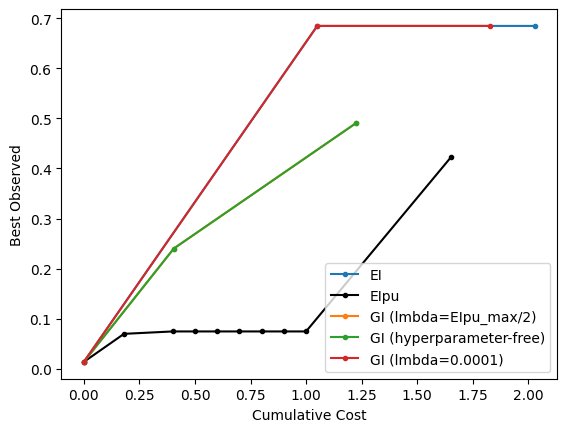

In [16]:
plt.plot(EI_cumulative_cost_history, EI_best, '.-', label="EI")
plt.plot(EIpu_cumulative_cost_history, EIpu_best, '.-', label="EIpu", color='black')
plt.plot(GI_cumulative_cost_history, GI_best, '.-', label="GI (lmbda=EIpu_max/2)")
plt.plot(GIfree_cumulative_cost_history, GIfree_best, '.-', label="GI (hyperparameter-free)")
plt.plot(GIlmbda_cumulative_cost_history, GIlmbda_best, '.-', label="GI (lmbda=0.0001)")
plt.xlabel('Cumulative Cost')
plt.ylabel('Best Observed')
plt.legend()

### Question
- Shall we caculate the average regret rather than the average best observed value across different instances?

- Shall we set a larger budget?

### TODO
- A sweep with different smoothness, lengthscales and seeds